In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
physical_devices = tensorflow.config.experimental.list_physical_devices('GPU')
if len(physical_devices)>0:
    tensorflow.config.experimental.set_memory_growth(physical_devices[0], True)



##### Loading and preprocessing data

In [3]:
#Train data
train_data = pd.read_csv('train_data.txt', sep = ':::',engine='python',names = ['Title', 'Genre', 'Description'])
train_data.head()

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [4]:
#Test data
test_data = pd.read_csv('test_data.txt',sep=':::',engine = 'python', names = ['ID','Title','Description'])
test_data.head()

,ID,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


In [5]:
#Test data solution

test_data_solution = pd.read_csv('test_data_solution.txt', sep = ':::', engine = 'python', names = ['ID', 'Title', 
'Genre','Description'])
test_data_solution.head()


,ID,Title,Genre,Description
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...


In [6]:
print(train_data.info())          #To check info about the dataframe
print()
print(train_data.isnull().sum())  #To check the number of null values in each column.

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
None

Title          0
Genre          0
Description    0
dtype: int64


In [7]:
len_description = train_data['Description'].apply(len)     #Here we add a new column to the dataframe, which
train_data['Length']=len_description                       #contains the length of the description of each movie
train_data.head()


,Title,Genre,Description,Length
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625


##### Data cleaning

In [8]:
stemmer1 = LancasterStemmer()
stopwords =set(stopwords.words('english'))

def cleaning(text):                #to clean the description of unnecessary things

    text = text.lower()
    text = re.sub('-',' ',text.lower())
    text = re.sub(f'[{string.digits}]',' ',text)

    text =' '.join([stemmer1.stem(word1) for word1 in text.split() if word1 not in stopwords])
    #to remove the stopwords and stem the remaining words and separate by a space

    text = re.sub(r'@\S+','',text) #removing usernames and handles
    text = re.sub(r'http\S+','',text)
    text = re.sub(r'www\S+','',text)
    text = re.sub(r'pic.\S+','',text)
    text = re.sub(r"[^a-zA-Z+']",' ',text) #removing all the non-alphabetic characters
    text = re.sub(r'\s+[a-zA-Z]\s+',' ',text+' ') #removing single characters generated because of the above step
    text = "".join([i for i in text if i not in string.punctuation])

    words = nltk.tokenize.word_tokenize(text, language = "english", preserve_line=True)    #we again tokenize the words and remove the stopwords
    remv_stpwrds = nltk.corpus.stopwords.words('english')                                
    text = " ".join([i for i in words if i not in remv_stpwrds and len(i)>2])

    text = re.sub("\s[\s]+"," ",text).strip()     #to remove extra spaces

    return re.sub(f'[{re.escape(string.punctuation)}]', '', text) 


train_data['Cleaned_description'] = train_data['Description'].apply(cleaning)
test_data['Cleaned_description'] = test_data['Description'].apply(cleaning)

train_data.head()

,Title,Genre,Description,Length,Cleaned_description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,list convers doct parents year old osc learn n...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,broth sist past incestu rel cur murd relations...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,bus empty stud field trip muse nat history lit...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,help unemploy fath mak end meet edi twin sist ...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,films titl ref recov body ground zero also sta...


In [9]:
len_cleaned = train_data['Cleaned_description'].apply(len)
train_data['Cleaned_length'] = len_cleaned
train_data.head()

,Title,Genre,Description,Length,Cleaned_description,Cleaned_length
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,list convers doct parents year old osc learn n...,324
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,broth sist past incestu rel cur murd relations...,83
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,bus empty stud field trip muse nat history lit...,325
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,help unemploy fath mak end meet edi twin sist ...,616
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,films titl ref recov body ground zero also sta...,282


In [10]:
print (train_data.describe())
print()
print((train_data['Cleaned_length']>2000).value_counts())

             Length  Cleaned_length
count  54214.000000    54214.000000
mean     600.452429      332.546187
std      446.026620      246.557190
min       42.000000       22.000000
25%      325.000000      180.000000
50%      464.000000      257.000000
75%      713.000000      398.000000
max    10504.000000     5777.000000

Cleaned_length
False    54131
True        83
Name: count, dtype: int64


In [11]:
#Removing extremely long descriptions that remained even after cleaning

print("Data_length before removing : ", len(train_data))
remove = train_data['Cleaned_length']>2000                    #We remove the rows with description length greater than 2000
train_data.drop(train_data[remove].index,axis=0,inplace=True)
print("Data_length after removing : ",len(train_data))

print(f'Number of rows removed :{remove.sum()}')

Data_length before removing :  54214
Data_length after removing :  54131
Number of rows removed :83


##### Tokenization

In [12]:
max_vocab = 50000 #Tokenizer will consider only first 50,000 most frequent words in the vocabulary
max_len = 250     #max length of each text sequence

tokenizer = Tokenizer(num_words = max_vocab, filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{/}~', lower = True)
#specifies the maximum number of words in vocabulary, filters out specific characters, and converts all words to lowercase

tokenizer.fit_on_texts(train_data['Cleaned_description'].values)  #fitting the tokenizer on the cleaned descriptions
#building the vocabulary

##### Vectorization using TF-IDF

In [13]:
X = tokenizer.texts_to_sequences(train_data['Cleaned_description'].values)
X = pad_sequences(X, maxlen = max_len) #padding the sequences to make them of equal length

Y = pd.get_dummies(train_data['Genre']).values  #converting the genres(in train_data) into one-hot encoded vectors

X_test = tokenizer.texts_to_sequences(test_data['Cleaned_description'].values)
X_test = pad_sequences(X_test, maxlen = max_len)

Y_test = pd.get_dummies(test_data_solution['Genre']).values  #converting the genres(in test_data_solution)
                                                             #into one hot encoded vectors

In [14]:
#Model
EMBEDDING_DIM = 100

model = Sequential() 

model.add(Embedding(max_vocab, EMBEDDING_DIM, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout = 0.1, recurrent_dropout = 0.2))
model.add(Dense( 27, activation = 'Softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

#Trainning the model

my_callbacks = [EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 2, mode = 'auto')]

history = model.fit(X, Y, epochs = 8, batch_size = 32, validation_data = (X_test, Y_test), callbacks = my_callbacks)
model.save('Movie_genre_classification.h5')

Epoch 1/8
1692/1692 [==============================] - 1547s 912ms/step - loss: 1.9267 - accuracy: 0.4408 - val_loss: 1.6737 - val_accuracy: 0.5181
Epoch 2/8
1692/1692 [==============================] - 1957s 1s/step - loss: 1.4293 - accuracy: 0.5871 - val_loss: 1.5631 - val_accuracy: 0.5469
Epoch 3/8
1692/1692 [==============================] - 2183s 1s/step - loss: 1.1139 - accuracy: 0.6756 - val_loss: 1.5807 - val_accuracy: 0.5468
Epoch 4/8
1692/1692 [==============================] - 2154s 1s/step - loss: 0.8497 - accuracy: 0.7520 - val_loss: 1.6913 - val_accuracy: 0.5339


c:\Users\Subham\miniconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##### Vizualizing results

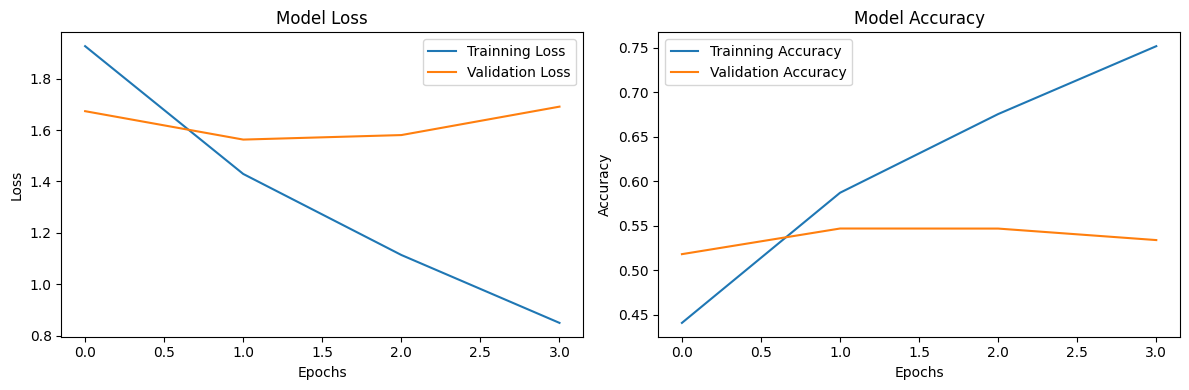

In [15]:
#Loss and accuracy plots

plt.figure(figsize=(12,4))

#Loss Plot
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Trainning Loss')
plt.plot(history.history['val_loss'], label ='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#Accuracy Plot
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label = 'Trainning Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

1694/1694 [==============================] - 160s 94ms/step


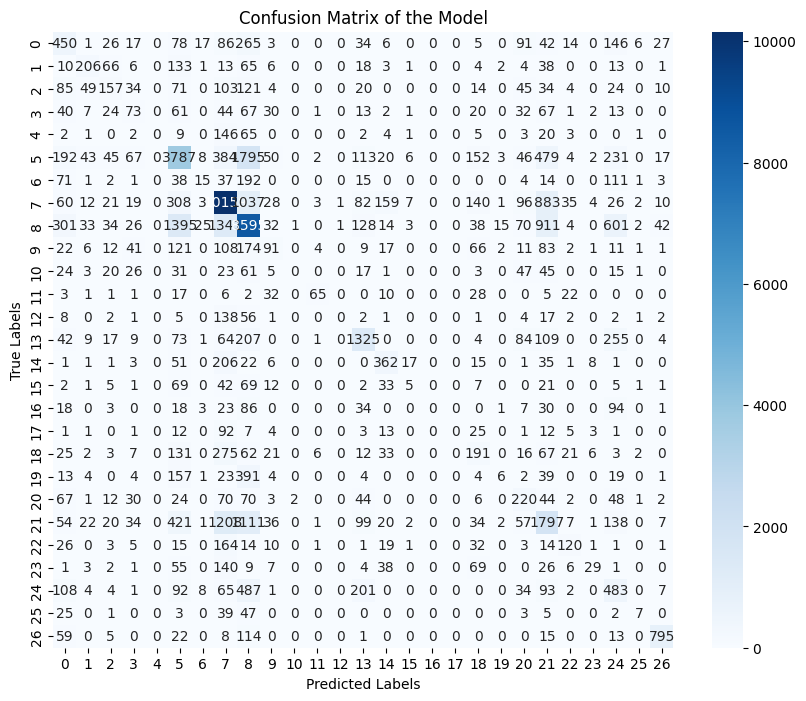

In [16]:
#Confusion matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)

conf_matrix = confusion_matrix(np.argmax(Y_test, axis=1), Y_pred_classes)

#Plotting the matrix
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of the Model')
plt.show()


